# This example shows the use of GY-elemnt in multi-domain model (electrical motor)


In [1]:

import sys
sys.path.append("../../")
from bond_graph_simulation.core.base import ElementFactory
from bond_graph_simulation.core.BondGraph2 import BondGraphModel
from bond_graph_simulation.rules.engine import RuleEngine
from bond_graph_simulation.equations.generator import EquationGenerator
from bond_graph_simulation.equations.statespace import CauchyFormGenerator
from bond_graph_simulation.equations.statespace import StateSpaceBuilder
from bond_graph_simulation.numerical.simulation import BondGraphSimulator


from bond_graph_simulation.inout.visualizer import draw_bond_graph, custom_layered_layout

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

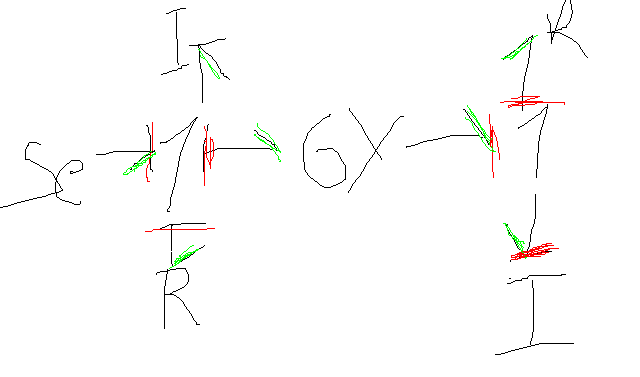

In [2]:

model = BondGraphModel(name='GY model example')#  Create model

#Create some elements
# ZeroJ_1 = ElementFactory.create('0', name='0j_2',)
# SF_1 = ElementFactory.create('SF', name='SF_1', )

GY_1 = ElementFactory.create('GY')

SE_1 = ElementFactory.create('SE', name='SE_1', )
R_1 = ElementFactory.create('R', name='R_1', )
R_2 = ElementFactory.create('R', name='R_2', )
I_1 = ElementFactory.create('I', name='I_1',)
I_2 = ElementFactory.create('I', name='I_2',)

OneJ_1 = ElementFactory.create('1', name='1j_4')
OneJ_2 = ElementFactory.create('1', name='1j_5')


In [3]:
# add a connections between elements in model
model.connect(SE_1, OneJ_1)
model.connect(I_1, OneJ_1)
model.connect(R_1, OneJ_1)
model.connect(GY_1, OneJ_1)
model.connect(GY_1, OneJ_2)
model.connect(OneJ_2, I_2)

model.connect(R_2, OneJ_2)


In [4]:
engine = RuleEngine(model, debug=False)
engine.apply_all()

In [5]:
problems = engine.find_invalid_bonds()
if problems:
    print("Detected some unvalid bonds:")
    for p in problems:
        print(p)
else:
    print("Allright!")

Allright!


## Checking model params

nodes len=  8


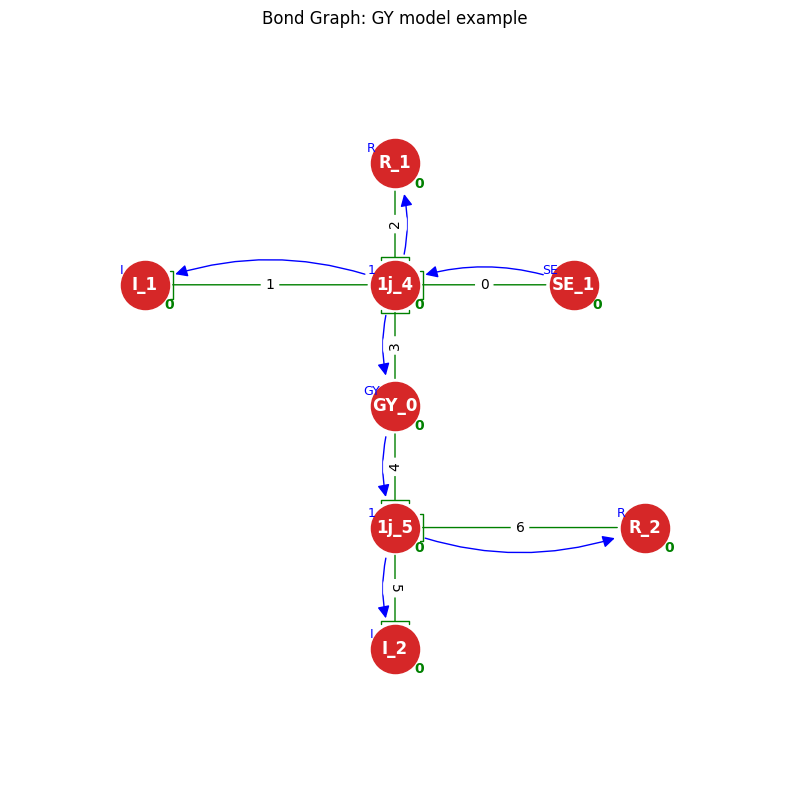

In [6]:

custom_layered_layout(model)

# Draw the graph
draw_bond_graph(model)

## State-space form sequence

In [7]:
# 5) Generate equations (NOT NESS later Cochy will do it)
eqgen = EquationGenerator(model, debug=True)
eqs = eqgen.generate_equations()
# eqgen.visualize_equations()
print(eqs)

[GY] GY_0: bonds 3 <-> 4: e1=m*f2, e2=m*f1
[EquationGenerator] Generated equations:
   Eq(e0, SE1)
   Eq(f1, p4/I4)
   Eq(e2, R2*f2)
   Eq(f5, p5/I5)
   Eq(e6, R3*f6)
   Eq(e3, f4*m0)
   Eq(e4, f3*m0)
   Eq(f1, f0)
   Eq(f2, f0)
   Eq(f3, f0)
   Eq(e0 - e1 - e2 - e3, 0)
   Eq(f5, f4)
   Eq(f6, f4)
   Eq(e4 - e5 - e6, 0)
[Eq(e0, SE1), Eq(f1, p4/I4), Eq(e2, R2*f2), Eq(f5, p5/I5), Eq(e6, R3*f6), Eq(e3, f4*m0), Eq(e4, f3*m0), Eq(f1, f0), Eq(f2, f0), Eq(f3, f0), Eq(e0 - e1 - e2 - e3, 0), Eq(f5, f4), Eq(f6, f4), Eq(e4 - e5 - e6, 0)]


In [8]:
cform = CauchyFormGenerator(model, debug=False)
# cform.debug = True
eqs = cform.build_cauchy_form()
print(eqs)

self.final_vars =  [SE1, p4, I4, R2, m0, p5, I5, R3]
START RECURECIEVE SUBS

[CAUCHY STATE 1] Исходное: dotp4 = e1

[CAUCHY STATE 2] Исходное: dotp5 = e5
[Eq(dotp4, SE1 - m0*p5/I5 - R2*p4/I4), Eq(dotp5, -R3*p5/I5 + m0*p4/I4)]


In [9]:
print("User have to define the output variables for the system to make possive the output equations generation")
print(cform.get_all_ef_variables())

User have to define the output variables for the system to make possive the output equations generation
[e0, e1, e2, e3, e4, e5, e6, f0, f1, f2, f3, f4, f5, f6]


In [10]:
# cform.interactive_generate_output_equations()
# Instead of input we can provide variables via code
cform.generate_output_equations('e6,f6')

Debug state: False
Entered list ['e6', 'f6']
symb entered list [e6, f6]

[OUTPUT] ROW Eq for output variable: e6 [<class 'sympy.core.symbol.Symbol'>]

[OUTPUT] ROW Eq for output variable: f6 [<class 'sympy.core.symbol.Symbol'>]

[INFO] Output equations:
Eq(e6, R3*f6)
Eq(f6, e6/R3)

[OUTPUT] Generating output equation for: 1

[CAUCHY OUT 1] Исходное: e6 = R3*f6
my_subs {f6: p5/I5}

[OUTPUT] Generating output equation for: 2

[CAUCHY OUT 2] Исходное: f6 = e6/R3
my_subs {e6: R3*p5/I5}


[Eq(e6, R3*p5/I5), Eq(f6, p5/I5)]

In [11]:
print(f"System has variables:{cform.final_vars}")

System has variables:[SE1, p4, I4, R2, m0, p5, I5, R3]


## Make state-space eq in matrix from

In [12]:
ssb = StateSpaceBuilder(model, cform, debug=False)
A, B, C, D = ssb.build_state_space()

In [13]:
ssb.x_vars, ssb.u_vars

([p4, p5], [SE1])

In [14]:
A, B , C, D 

(Matrix([
 [-R2/I4, -m0/I5],
 [ m0/I4, -R3/I5]]),
 Matrix([
 [1],
 [0]]),
 Matrix([
 [0, R3/I5],
 [0,  1/I5]]),
 Matrix([
 [0],
 [0]]))

## Make numerical matrixes from symbolic

In [15]:
sim = BondGraphSimulator(model, ssb)

sim.print_simulation_requirements()  # shows the required parameters (order is important)

=== Required Data for Numerical Simulation ===
System parameters (provide param_values: dict[str, float]):
    I4, I5, R2, R3, m0
   Example: param_values = {'R1': 10.0, 'C2': 0.001, 'L3': 0.1}

State variables (provide x0: list[float], in the same order):
    p4, p5
   Example: x0 = [0.0, 0.0]   # (e.g., q2=0, p3=0)
[p4, p5]
Input variables (provide u_func: Callable[[float], list[float]], in the same order):
    SE1
   Example: u_func = lambda t: [1.0]   # if a single input, e.g., SE0=1 always
           u_func = lambda t: [np.sin(t)]  # sinusoidal input
-------------------------------------------------------
Full function call:
  result = sim.simulate(param_values, t_span=(0, 5), x0=x0, u_func=u_func)
  t, y = result['t'], result['y']


In [16]:
initial_state = [0.0] * len(sim.ss.x_vars) # fill zeros or define custom list as shown in DEMO 1
num_steps  = 501
input_sequence = [[1.0, 0.0] for _ in range(num_steps)] # inputs N=2 if custom
subi = [0.0]*len(sim.ss.u_vars)
input_sequence = [subi for _ in range(num_steps)] # inputs are zeros
# lets set all velocity 0 (fixed frame), and forces 1 (suppose gravity)
for ix, u in enumerate(sim.ss.u_vars):
    for i in range(num_steps):
        if str(u)[:2] == 'SE':
            input_sequence[i][ix] = 1.0


In [17]:
input_sequence

[[1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],


In [18]:
simulation_time_to = 40 # sec
time_steps = np.linspace(0, simulation_time_to, num_steps)
sampling_period = time_steps[1] - time_steps[0] # sampling_period=0.05


print("Give parameter values for the simulation as a dictionary {param_name: value}")
print(f"param names:{sim.param_names}")

Give parameter values for the simulation as a dictionary {param_name: value}
param names:['I4', 'I5', 'R2', 'R3', 'm0']


In [19]:
# Manually defined parameter values for simulation
# parameter_values = {'C3': 1/1.1, 'I2': 1.01, 'R1': 1.01} # С is complaence (not stifness K)
parameter_values = {'I4':1, 'I5':0.5,'R2':0.5, 'R3':0.5, 'm0':2}

# Automatically fill parameter values by devault values
parameter_values = {}
for p_name in sim.param_names:
    if 'I' in p_name:
        parameter_values[p_name] = 1.0
    elif 'C' in p_name:
        parameter_values[p_name] = 10.0
    elif 'R' in p_name:
        parameter_values[p_name] = 1.5
    elif 'm' in p_name:
        parameter_values[p_name] = 2.0
    elif 'n' in p_name:
        parameter_values[p_name] = 2.0
    else:
        parameter_values[p_name] = 0.0
print("Using parameter values:", parameter_values)

result = sim.simulate(initial_state, input_sequence, time_steps, sampling_period, parameter_values)


Using parameter values: {'I4': 1.0, 'I5': 1.0, 'R2': 1.5, 'R3': 1.5, 'm0': 2.0}


## Make numerical matrixes from symbolic

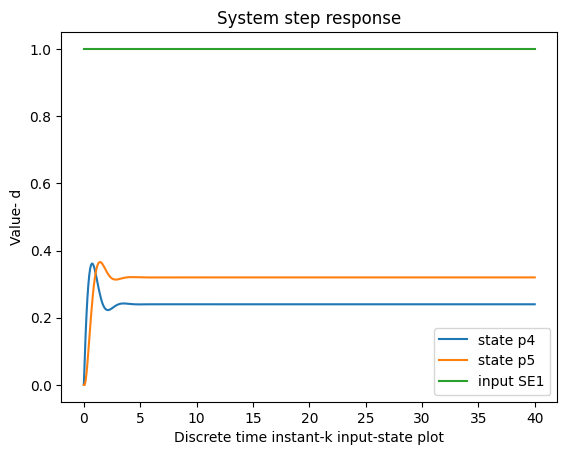

In [20]:
for ix, state_name in enumerate(sim.ss.x_vars):
    plt.plot(result['t'], result['x'][:,ix], label={"state " + str(state_name)})
    
for ix, input_name in enumerate(sim.ss.u_vars):
    plt.plot(result['t'], result['u'][:,ix], label={"input "+ str(input_name)})

plt.xlabel('Discrete time instant-k input-state plot')
plt.ylabel('Value- d')

plt.title('System step response')
plt.legend()
plt.show()

y.shape= (501, 2)
output_names= ['y1', 'y2']


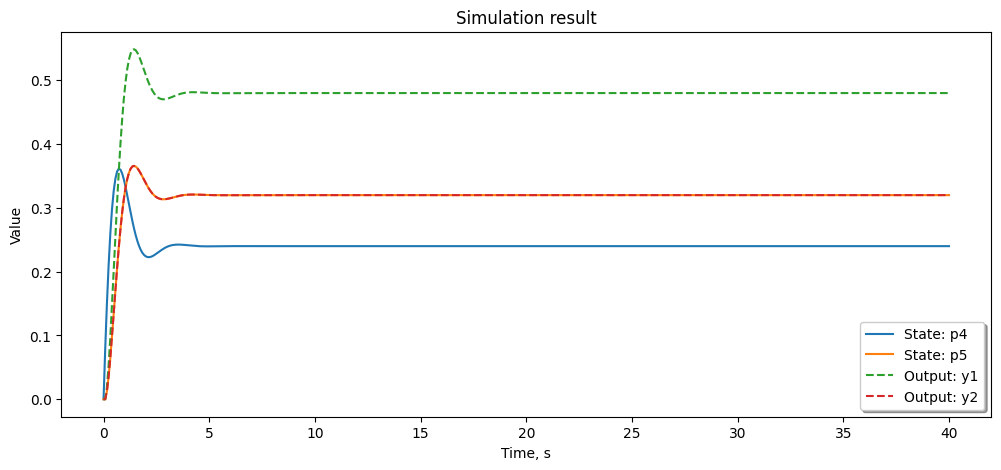

In [21]:
state_names = [str(s) for s in sim.ss.x_vars]        # ['q2', 'p3', ...]
output_names = [str(y) for y in sim.ss.output_vars]  # ['e4', 'f7', ...]

sim.plot_simulation_result(result, state_names, output_names)